In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from datetime import datetime
import statistics
import re
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, auc, classification_report, plot_confusion_matrix, recall_score, precision_recall_curve, roc_auc_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [53]:
from collections import Counter
from imblearn.over_sampling import ADASYN
from numpy import where
from imblearn.over_sampling import SMOTE

# Subsamping - Introduction
Alongside the modelling carried out with Vaex, in order to explore whether the volume of data makes a material difference to model scores, I wanted to also attempt modelling below using subsampling. The data imported is the same data we used for the our last Vaex model, with SMOTE applied to fix the class imbalance. This data is then split into a regular Test and Train set, with the target (y) removed into y_train and y_test. The data is subsampled to reduce the number of observations to a point where the analysis can be carried out locally.

### Imports & Setting the Scene

In [54]:
df_train = pd.read_csv('sm_train.csv')
df_test = pd.read_csv('sm_test.csv')

In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267988 entries, 0 to 267987
Data columns (total 40 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            267988 non-null  int64  
 1   frequency_encoded_conflict_name       267988 non-null  float64
 2   frequency_encoded_dyad_name           267988 non-null  float64
 3   frequency_encoded_side_a              267988 non-null  float64
 4   frequency_encoded_side_b              267988 non-null  float64
 5   frequency_encoded_source_original     267988 non-null  float64
 6   frequency_encoded_where_coordinates   267988 non-null  float64
 7   frequency_encoded_where_description   267988 non-null  float64
 8   frequency_encoded_adm_1               267988 non-null  float64
 9   frequency_encoded_country             267988 non-null  float64
 10  frequency_encoded_media_org_source    267988 non-null  float64
 11  

In [56]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50505 entries, 0 to 50504
Data columns (total 40 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            50505 non-null  int64  
 1   frequency_encoded_conflict_name       50505 non-null  float64
 2   frequency_encoded_dyad_name           50505 non-null  float64
 3   frequency_encoded_side_a              50505 non-null  float64
 4   frequency_encoded_side_b              50505 non-null  float64
 5   frequency_encoded_source_original     50505 non-null  float64
 6   frequency_encoded_where_coordinates   50505 non-null  float64
 7   frequency_encoded_where_description   50505 non-null  float64
 8   frequency_encoded_adm_1               50505 non-null  float64
 9   frequency_encoded_country             50505 non-null  float64
 10  frequency_encoded_media_org_source    50505 non-null  float64
 11  label_encoded_a

#### Reducing Sample Size

In [57]:
df_train_sample = df_train.sample(50000)
df_test_sample = df_test.sample(20000)

In [58]:
df_train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 33863 to 172256
Data columns (total 40 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            50000 non-null  int64  
 1   frequency_encoded_conflict_name       50000 non-null  float64
 2   frequency_encoded_dyad_name           50000 non-null  float64
 3   frequency_encoded_side_a              50000 non-null  float64
 4   frequency_encoded_side_b              50000 non-null  float64
 5   frequency_encoded_source_original     50000 non-null  float64
 6   frequency_encoded_where_coordinates   50000 non-null  float64
 7   frequency_encoded_where_description   50000 non-null  float64
 8   frequency_encoded_adm_1               50000 non-null  float64
 9   frequency_encoded_country             50000 non-null  float64
 10  frequency_encoded_media_org_source    50000 non-null  float64
 11  label_enco

In [59]:
df_train_sample.incident_classification.value_counts()

3    12582
0    12516
1    12468
2    12434
Name: incident_classification, dtype: int64

In [60]:
df_test_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 43537 to 27267
Data columns (total 40 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            20000 non-null  int64  
 1   frequency_encoded_conflict_name       20000 non-null  float64
 2   frequency_encoded_dyad_name           20000 non-null  float64
 3   frequency_encoded_side_a              20000 non-null  float64
 4   frequency_encoded_side_b              20000 non-null  float64
 5   frequency_encoded_source_original     20000 non-null  float64
 6   frequency_encoded_where_coordinates   20000 non-null  float64
 7   frequency_encoded_where_description   20000 non-null  float64
 8   frequency_encoded_adm_1               20000 non-null  float64
 9   frequency_encoded_country             20000 non-null  float64
 10  frequency_encoded_media_org_source    20000 non-null  float64
 11  label_encod

In [61]:
df_test_sample.incident_classification.value_counts()

0    11501
1     6469
2     1973
3       57
Name: incident_classification, dtype: int64

##### Note:
It is worthwhile remembering here as we only apply SMOTE to the training sets, the class proportions in "df_test_sample" are not balanced.

In [62]:
y_train = df_train_sample.pop('incident_classification')
X_train = df_train_sample
y_test = df_test_sample.pop('incident_classification')
X_test = df_test_sample

In [63]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logistic Regression

In [14]:
model = LogisticRegression(multi_class='ovr', max_iter=10000)
model.fit(X_train, y_train)
print("Training Score is: ", model.score(X_train, y_train))
print("Test Score is: ", model.score(X_test, y_test))
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)

model_cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("Your CV Scores are: ", model_cv_scores)
print("Your Mean CV Score is: ", np.mean(model_cv_scores))

Training Score is:  0.71606
Test Score is:  0.58585
Your CV Scores are:  [0.7189 0.7144 0.7096 0.713  0.7144]
Your Mean CV Score is:  0.71406


In [15]:
print(f'Accuracy Score: {accuracy_score(y_test,predictions)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, predictions)}')

Accuracy Score: 0.58585
Confusion Matrix: 
[[10215  1178     5     0]
 [ 5053  1501     3     0]
 [ 1458   533     1     0]
 [   50     3     0     0]]


In [16]:
print(metrics.classification_report(y_test, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.61      0.90      0.73     11398
           1       0.47      0.23      0.31      6557
           2       0.11      0.00      0.00      1992
           3       0.00      0.00      0.00        53

    accuracy                           0.59     20000
   macro avg       0.30      0.28      0.26     20000
weighted avg       0.51      0.59      0.51     20000



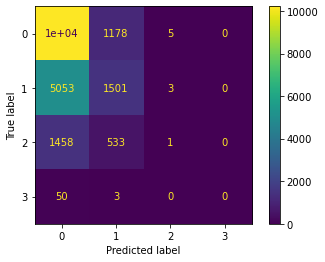

In [17]:
plot_confusion_matrix(model, X_test, y_test)

###### Note:
Not terrible results, but there is a clear problem for the model in identifying Class 2 and Class 3 events.

#### GridSearch

In [18]:
lr = LogisticRegression()
params = {'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': np.logspace(-4, 4, 9), }

search = GridSearchCV(lr, params, cv=5, n_jobs=8, verbose=2)
search.fit(X_train, y_train)

print('Best parameters: ', search.best_params_)
print('This is the best score: ', search.best_score_)
print('Test score: ', search.score(X_test, y_test))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters:  {'C': 10000.0, 'penalty': 'l2', 'solver': 'liblinear'}
This is the best score:  0.7146600000000001
Test score:  0.58685


#### Model With GridSearch Params

In [19]:
grid_model = LogisticRegression(multi_class='ovr', max_iter=10000, penalty='l2', solver='liblinear', C=10000)
grid_model.fit(X_train, y_train)
print("Training Score is: ", grid_model.score(X_train, y_train))
print("Test Score is: ", grid_model.score(X_test, y_test))
predictions_g = grid_model.predict(X_test)
probabilities_g = grid_model.predict_proba(X_test)

grid_model_cv_scores = cross_val_score(grid_model, X_train, y_train, cv=5)
print("Your CV Scores are: ", grid_model_cv_scores)
print("Your Mean CV Score is: ", np.mean(grid_model_cv_scores))

Training Score is:  0.71638
Test Score is:  0.58685
Your CV Scores are:  [0.7193 0.7149 0.7103 0.7133 0.7155]
Your Mean CV Score is:  0.7146600000000001


In [20]:
print(f'Accuracy Score: {accuracy_score(y_test, predictions_g)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, predictions_g)}')
#print(f'Area Under Curve: {roc_auc_score(y_test, predictions)}')
#print(f'Recall score: {recall_score(y_test,predictions)}')

Accuracy Score: 0.58685
Confusion Matrix: 
[[10219  1174     5     0]
 [ 5037  1517     3     0]
 [ 1445   546     1     0]
 [   50     3     0     0]]


In [21]:
print(metrics.classification_report(y_test, predictions_g))

              precision    recall  f1-score   support

           0       0.61      0.90      0.73     11398
           1       0.47      0.23      0.31      6557
           2       0.11      0.00      0.00      1992
           3       0.00      0.00      0.00        53

    accuracy                           0.59     20000
   macro avg       0.30      0.28      0.26     20000
weighted avg       0.51      0.59      0.52     20000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


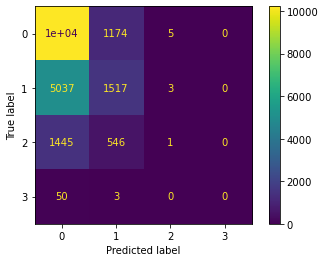

In [22]:
plot_confusion_matrix(grid_model, X_test, y_test)

###### Note:
Using the Grid Search parameters, the model is able to achieve every so slightly higher results, however, there is still a remaining problem with the model struggling to successfully classify Class 2 and Class 3 events.

### Model 2 - LogReg With Class Weightings
Adding weightings to the the classes to see if we can push the model into to more successfully classifying the tougher categories.

In [31]:
w = {0:40, 1:50, 2:70, 3:60}

model = LogisticRegression(multi_class='ovr', 
                           max_iter=10000, 
                           penalty='l2', 
                           solver='liblinear',
                           class_weight=w,
                           C=10000)
model.fit(X_train, y_train)
print("Training Score is: ", model.score(X_train, y_train))
print("Test Score is: ", model.score(X_test, y_test))
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)

model_cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("Your CV Scores are: ", model_cv_scores)
print("Your Mean CV Score is: ", np.mean(model_cv_scores))

Training Score is:  0.66174
Test Score is:  0.5837
Your CV Scores are:  [0.6643 0.659  0.6579 0.66   0.6598]
Your Mean CV Score is:  0.6602000000000001


In [34]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.61      0.90      0.72     11398
           1       0.47      0.22      0.29      6557
           2       0.00      0.00      0.00      1992
           3       0.15      0.11      0.13        53

    accuracy                           0.58     20000
   macro avg       0.30      0.31      0.29     20000
weighted avg       0.50      0.58      0.51     20000



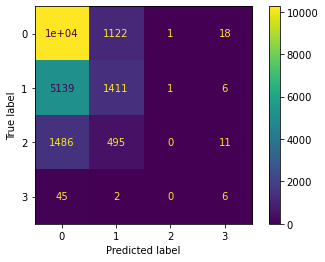

In [32]:
plot_confusion_matrix(model, X_test, y_test)

###### Note:
Using weightings on the classes does make the model ever so slightly better at predicting Class 3 and 4 labels, at the expense of a slight decrease in scores. I would like to explore whether there is a way to include the weightings in a Grid Search, as opposed to changing values manually.

### Modelling With Data Encoded by One Hot Encoder and LabelEncoder
I leave this section in to demonstrate thought process and that an attempt was made to dummify categorical features, and model with higher dimension data. This ultimately, even with a much smaller sample size of data, was too computationally intensive without doing a PCA or working with a sparse matrix. These are two further steps I would like to explore as this project develops further.

In [ ]:
df = pd.read_csv('to_model.csv')

In [ ]:
df.info()

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('deaths_unknown', axis=1, inplace=True)

In [ ]:
df.incident_classification.value_counts(normalize=True)

In [ ]:
very_high = df[(df['incident_classification'] == 3)]
high = df[(df['incident_classification'] == 2)].sample(5000)
moderate = df[(df['incident_classification'] == 1)].sample(5000)
low = df[(df['incident_classification'] == 0)].sample(5000)

In [ ]:
balanced_df = pd.concat([very_high.reset_index(), high.reset_index(), moderate.reset_index(), low.reset_index()])

In [ ]:
balanced_df.incident_classification.value_counts()

In [ ]:
balanced_df.info()

In [ ]:
le = preprocessing.LabelEncoder()
balanced_df.conflict_name = le.fit_transform(balanced_df.conflict_name)
balanced_df.dyad_name = le.fit_transform(balanced_df.dyad_name)
balanced_df.side_a = le.fit_transform(balanced_df.side_a)
balanced_df.side_b = le.fit_transform(balanced_df.side_b)
balanced_df.source_original = le.fit_transform(balanced_df.source_original)
balanced_df.where_coordinates = le.fit_transform(balanced_df.where_coordinates)
balanced_df.where_description = le.fit_transform(balanced_df.where_description)
balanced_df.adm_1 = le.fit_transform(balanced_df.adm_1)
balanced_df.media_org_source = le.fit_transform(balanced_df.media_org_source)

In [ ]:
balanced_df.drop('index', axis=1, inplace=True)

In [ ]:
balanced_df = pd.get_dummies(balanced_df, columns=['year', 'active_year', 'type_of_violence', 'conflict_name', 'dyad_name', 'side_a', 'side_b', 'source_original', 'where_coordinates', 'where_description', 'adm_1', 'country', 'region', 'media_org_source'])

In [ ]:
balanced_df.reset_index(inplace=True)

In [ ]:
balanced_df.drop('index', axis=1, inplace=True)

In [ ]:
y = balanced_df.pop('incident_classification')
X = balanced_df

In [ ]:
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(
     X, y, test_size=0.2, random_state=1)

In [ ]:
scaler = StandardScaler()
X_sm_train = scaler.fit_transform(X_sm_train)
X_sm_test = scaler.transform(X_sm_test)

In [ ]:
oversample = SMOTE()
X_sm_train, y_sm_train = oversample.fit_resample(X_sm_train, y_sm_train)

In [ ]:
y_sm_train.value_counts(normalize=True)

### Logistic Regression on OHE Data


In [ ]:
##Using same parameters as GridSearch above

ohe_model = LogisticRegression(multi_class='ovr', max_iter=10000, penalty='l2', solver='liblinear', C=1000)
ohe_model.fit(X_sm_train, y_sm_train)
print("Training Score is: ", ohe_model.score(X_sm_train, y_sm_train))
print("Test Score is: ", ohe_model.score(X_sm_train, y_sm_train))
predictions_ohe = ohe_model.predict(X_sm_test)
probabilities_ohe = ohe_model.predict_proba(X_sm_test)

ohe_model_cv_scores = cross_val_score(ohe_model, X_sm_train, y_sm_train, cv=5)
print("Your CV Scores are: ", ohe_model_cv_scores)
print("Your Mean CV Score is: ", np.mean(ohe_model_cv_scores))

##### Grid Search

In [ ]:
lr = LogisticRegression()
params = {'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': np.logspace(-4, 4, 9), }

search = GridSearchCV(lr, params, cv=5, n_jobs=8, verbose=2)
search.fit(X_sm_train, y_sm_train)

print('Best parameters: ', search.best_params_)
print('This is the best score: ', search.best_score_)
print('Test score: ', search.score(X_sm_test, y_sm_test))

### Further Models
Further to the main modelling techniques used so far, I wanted to attempt to use a handful of other models which research suggested worked well for multi class classification problems. Namely network based models, decision trees and bagging classifiers. Interestingly none of these models outperformed the XGB model.

#### Multi-Layer Perceptron Classifier

In [64]:
from sklearn.neural_network import MLPClassifier

In [65]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(15,), max_iter=10000, random_state=1)
clf.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(15,), max_iter=10000,
              random_state=1, solver='lbfgs')

In [66]:
## Return the mean accuracy on the given test data and labels.
## In multi-label classification, this is the subset accuracy which is a harsh metric since you require 
## for each sample that each label set be correctly predicted.

clf.score(X_test, y_test)

0.6049

In [74]:
mlp_best = 0.6049

##### Winning MLP Stats

In [78]:
y_test_predict = clf.predict(X_test)

In [79]:
print(metrics.classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.68      0.80      0.73     11501
           1       0.46      0.39      0.42      6469
           2       0.33      0.14      0.19      1973
           3       0.29      0.25      0.26        57

    accuracy                           0.60     20000
   macro avg       0.44      0.39      0.40     20000
weighted avg       0.57      0.60      0.58     20000



In [81]:
confusion_matrix(y_test, y_test_predict)

array([[9200, 2040,  246,   15],
       [3636, 2538,  291,    4],
       [ 773,  916,  268,   16],
       [  17,    8,   18,   14]], dtype=int64)

##### Worse MLP models

In [68]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(50,), max_iter=10000, batch_size=500, random_state=1)
clf.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, batch_size=500, hidden_layer_sizes=(50,),
              max_iter=10000, random_state=1, solver='lbfgs')

In [69]:
clf.score(X_test, y_test)

0.601

In [70]:
clf.predict_log_proba(X_test)

array([[-4.33821697e-01, -1.15205471e+00, -3.32464299e+00,
        -1.91680391e+01],
       [-7.18228354e-01, -8.85517792e-01, -2.30393770e+00,
        -1.08570534e+01],
       [-1.49882623e+00, -7.39952294e-01, -1.21072982e+00,
        -6.50805479e+00],
       ...,
       [-1.89740259e-02, -3.98135377e+00, -8.91177998e+00,
        -3.30070257e+01],
       [-7.56771250e-01, -7.03028267e-01, -3.33190004e+00,
        -1.13134389e+01],
       [-9.31571349e-01, -1.01494965e+00, -1.58352435e+00,
        -3.25983694e+00]])

In [71]:
clf.predict(X_test)

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [72]:
clf3 = MLPClassifier(solver='adam', alpha=0.5,
                     hidden_layer_sizes=(50,), max_iter=10000, batch_size=1000, random_state=1)
clf3.fit(X_train, y_train)

MLPClassifier(alpha=0.5, batch_size=1000, hidden_layer_sizes=(50,),
              max_iter=10000, random_state=1)

In [73]:
clf3.score(X_test, y_test)

0.60225

#### Decision Tree

In [82]:
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [100]:
tree = DecisionTreeClassifier(max_depth=8, min_samples_split=2, min_samples_leaf=8)
tree.fit(X_train, y_train)

print(tree.score(X_train, y_train))
print(cross_val_score(tree, X_train, y_train, cv=5).mean())
print(tree.score(X_test, y_test))

0.82858
0.82304
0.60425


In [101]:
dtree_best = 0.60425

##### Winning Decision Stats

In [102]:
y_test_predict = tree.predict(X_test)

In [103]:
print(metrics.classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.65      0.85      0.74     11501
           1       0.47      0.33      0.39      6469
           2       0.35      0.06      0.10      1973
           3       0.00      0.00      0.00        57

    accuracy                           0.60     20000
   macro avg       0.37      0.31      0.31     20000
weighted avg       0.56      0.60      0.56     20000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
confusion_matrix(y_test, y_test_predict)

array([[9811, 1614,   76,    0],
       [4181, 2161,  127,    0],
       [1032,  828,  113,    0],
       [  33,   21,    3,    0]], dtype=int64)

##### Worse Decision Trees

In [85]:
tree = DecisionTreeClassifier(max_depth=8, min_samples_split=2, min_samples_leaf=8, max_features='log2')
tree.fit(X_train, y_train)

print(tree.score(X_train, y_train))
print(cross_val_score(tree, X_train, y_train, cv=5).mean())
print(tree.score(X_test, y_test))

0.66696
0.61706
0.52835


In [86]:
tree = DecisionTreeClassifier(max_depth=8, min_samples_split=2, min_samples_leaf=8, 
                              max_features='log2', min_impurity_decrease=0.5)
tree.fit(X_train, y_train)

print(tree.score(X_train, y_train))
print(cross_val_score(tree, X_train, y_train, cv=5).mean())
print(tree.score(X_test, y_test))

0.25164
0.25164
0.00285


### Bagging Model

In [88]:
bagging = BaggingClassifier(n_estimators=10, n_jobs=8, max_features=10)

bagging.fit(X_train, y_train)

print(bagging.score(X_train, y_train))
print(cross_val_score(bagging, X_train, y_train, cv=5).mean())
print(bagging.score(X_test, y_test))

0.93778
0.7771399999999999
0.5633


In [89]:
bagging = BaggingClassifier(n_estimators=20, n_jobs=8, max_features=20)

bagging.fit(X_train, y_train)

print(bagging.score(X_train, y_train))
print(cross_val_score(bagging, X_train, y_train, cv=5).mean())
print(bagging.score(X_test, y_test))

0.99282
0.8137800000000001
0.59795


In [90]:
bagging = BaggingClassifier(n_estimators=30, n_jobs=8, max_features=30, max_samples = 500)

bagging.fit(X_train, y_train)

print(bagging.score(X_train, y_train))
print(cross_val_score(bagging, X_train, y_train, cv=5).mean())
print(bagging.score(X_test, y_test))

0.82318
0.8181799999999999
0.5866


In [92]:
bagging_best = 0.5866

##### Winning Bagging Model Stats

In [105]:
y_test_predict = bagging.predict(X_test)

In [106]:
print(metrics.classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.65      0.82      0.72     11501
           1       0.44      0.33      0.38      6469
           2       0.32      0.10      0.15      1973
           3       0.00      0.00      0.00        57

    accuracy                           0.59     20000
   macro avg       0.35      0.31      0.31     20000
weighted avg       0.55      0.59      0.55     20000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
confusion_matrix(y_test, y_test_predict)

array([[9400, 1929,  172,    0],
       [4098, 2132,  239,    0],
       [1024,  749,  200,    0],
       [  44,    7,    6,    0]], dtype=int64)

### Model Roundup

In [108]:
test_scores = pd.DataFrame({'Grid_logreg ': grid_model.score(X_test, y_test),
                       'Logreg_cl_weight': model.score(X_test, y_test),
                       'MLP': mlp_best,
                       'Decision_Tree': dtree_best,
                       'Bagging': bagging_best},
                      index=['Model_Test_Scores'])

In [109]:
test_scores = test_scores.T

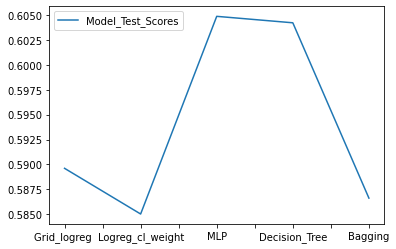

In [110]:
test_scores.plot()
plt.show()

## Summary

Overall, for the models run on a subsample of the data, the Multi-Layer Perceptron provided the best score, with a test score of 0.6049 against a baseline of 0.25. In particular the MLP with a lower number of hidden layers outperformed the rest. The decision tree model also performed well, providing only a slightly lower test score. However, comparing with the XGB model run with Vaex, the winner is the latter model with an accuracy score of 0.623. My hypothesis of why this is the case is due to the fact XGB models seem to be well suited to datasets with larger numbers of observations, and where there is a mixture of both continuous and categorical data.

As next steps for the modelling on this project I would like to further explore the following:
* Dummifying the categorical data with One Hot Encoder, approaching the added dimensionality with a PCA or a sparse matrix
* Modelling with a Tensorflow neural network